In [1]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
import Dans_Diffraction
import os
import scipy.optimize
def make_optics_geometry_plot(energy_kev, two_theta, d_tot):
    d0, dL, dn, M =  get_id06_be_lens_params(energy_kev, two_theta, d_tot)

    d0p = d0*np.cos(np.pi*two_theta/180)
    dLp = dL*np.cos(np.pi*two_theta/180)
    dnp = dn*np.cos(np.pi*two_theta/180)

    fig = plt.figure(figsize = (5,3), dpi = 300)
    ax = fig.add_axes([0, 0, 1, 1])
    d1_d2_fig = imageio.imread('d1_d2_fig.png')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.imshow(d1_d2_fig)
    ax.set_position([0, 0, 1, 1])

    ax.text(300, 590, f'$d_1$ = {d0:.2f}', rotation = 30, ha = 'center', va = 'center')
    ax.text(540, 440, f'$d_L$ = {dL:.2f}', rotation = 30, ha = 'center', va = 'center')
    ax.text(900, 245, f'$d_2$ = {dn:.2f}', rotation = 30, ha = 'center', va = 'center')

    ax.text(300, 875, f"$d_1'$ = {d0p:.2f}", ha = 'center', va = 'center')
    ax.text(590, 875, f"$d_L'$ = {dLp:.2f}", ha = 'center', va = 'center')
    ax.text(1000, 875, f"$d_2'$ = {dnp:.2f}", ha = 'center', va = 'center')

    ax.text(1380, 150, f"$M$ = {M:.2f}", rotation = -60, ha = 'center', va = 'center')
    return fig, ax

def get_dn(fs, ds):
    '''
    Consider a sample (s) and a numer of lenses with focusing power f# and distance between 
    each optical component (d#) as shown in the drawing below:
    s    d0    f0 d1 f2 d3 f3 d3 f4      dn   D
    x----------)(----)(----)(----)(-----------|
    This function gets distance from last lenslet to the detector (dn) for the image to be in focus at the detector (D)
    input:
        fs: list of floats, describing the thin-lens focusing power of each lenslet
        ds: list of floats, distances between optical components (first element is the sample-lenselet distance, aka d1 in most literature)
    returns:
        float, distance from last lenslet to the detector (dn)
    '''
    d = 0.0 # distance from source
    L = 0.0 # total distance
    for i, f in enumerate(fs):
        d += ds[i]
        L += ds[i]
        d = d*f/(f-d)
    return L-d

def get_magnification(fs,ds):
    '''
    calculates the magnification based on the distance between optical components
    input:
        fs: array-like of length n,   focal distance of each lenselet
        ds: array-like of length n+1, distance between each optical component (source-lenselet, lenselet-lenselet*(n-1), lenselet-detector)
    returns:
        float, magnification
    '''
    height = -1 #mm
    slope = height/-ds[0]
    d = -ds[0] # distance from intersection of height = 0
    for i, _ in enumerate(fs):
        height += slope*ds[i]
        d += ds[i]
        d = d*fs[i]/(fs[i]-d)
        if i>0:
            slope = height/d
        #print(i, slope, height, d)
        
    height += slope*ds[-1]
    return height # (heightin mm) == (height in mm)/(1 mm) == magnification 


def get_d1_d2_from_tot_d(fs, ds, d_tot, initial_guess):
    '''
    Gets both d1 and d2 (distance from sample to lens and from lens to detector) using get_dn for a fixed d_tot
    This function only works with a good initial guess. A suitable guess can be found by setting initial_guess = thin_lens_focal_distance+delta
    where delta is a small number i.e. 1
    input:
        fs: list of floats, describing the thin-lens focusing power of each lenslet
        ds: list of floats [len(ds) == len(fs)-1], distance between each lenslet 
        d_tot: float, total distance froms sample to detector
    return:
        d1, d2 (floats, distance sample to first lenslet, distance last lenselet to detector)
    '''
    ds = list(ds)
    dL = np.sum(ds) # total distance in lens box
    
    def fn(d0):
        return (d0 + dL + get_dn(fs, [d0]+ds) - d_tot)**2
    
    '''xs = np.arange(0,5000)
    y = [fn(x) for x in xs]
    fig, ax = plt.subplots()
    ax.plot(xs,y)
    ax.set_ylim([-0.001,1000000])
    #initial_guess = np.argmin(y)
    #print(initial_guess)'''
    return scipy.optimize.minimize(fn, initial_guess).x[0]

def get_id06_be_lens_params(energy_kev, two_theta, tot_length):
    '''
    returns the sample-lens-distance, lens-thickness, and lens-detector-distance when using the Be lens at id06
    input:
        energy_kev, float kev
        two_theta, float degrees
        tot_length, float mm
    returns:
        (sample-lens-distance, lens-thickness, and lens-detector-distance, magnification)
        first 3 in mm
    '''
    # get refractive index
    if not os.path.exists('cif_files'):
        os.makedirs('cif_files')
    url = 'http://www.crystallography.net/cod/9008488.cif'
    cif_file = 'cif_files/'+url.split('/')[-1]
    if not os.path.isfile(cif_file):
        r = requests.get(url)
        open(cif_file , 'wb').write(r.content)

    xtl = Dans_Diffraction.Crystal(cif_file)

    atom_type = xtl.Structure.type
    occ = xtl.Structure.occupancy
    natoms = np.sum(occ)
    vol = xtl.Cell.volume()
    atom_per_volume = 1 / vol  # atoms per A^3
    elements = ['%s%s' % (at, o) for at, o in zip(atom_type, occ)]

    n_comlex = Dans_Diffraction.fc.xray_refractive_index(elements, energy_kev, atom_per_volume)[0]
    
    # single lens prameters
    R = 50/1000 # 50 µm curvature
    n = n_comlex.real 
    δ = 1-n
    f = R/(2*δ)
        
    # lens array
    fs = [f]*88
    ds = [1.600]*68 +[2.000]*20
    f_tl = R/(2*δ*88) # thin-lens focal distance
    dL = np.sum(ds[:-1])
    #     
    d0 = get_d1_d2_from_tot_d(fs, ds[:-1], tot_length, f_tl)
    dn = tot_length - d0 - dL
    M = get_magnification(fs,[d0]+ds[:-1]+[dn])
    return d0, dL, dn, M

        
    

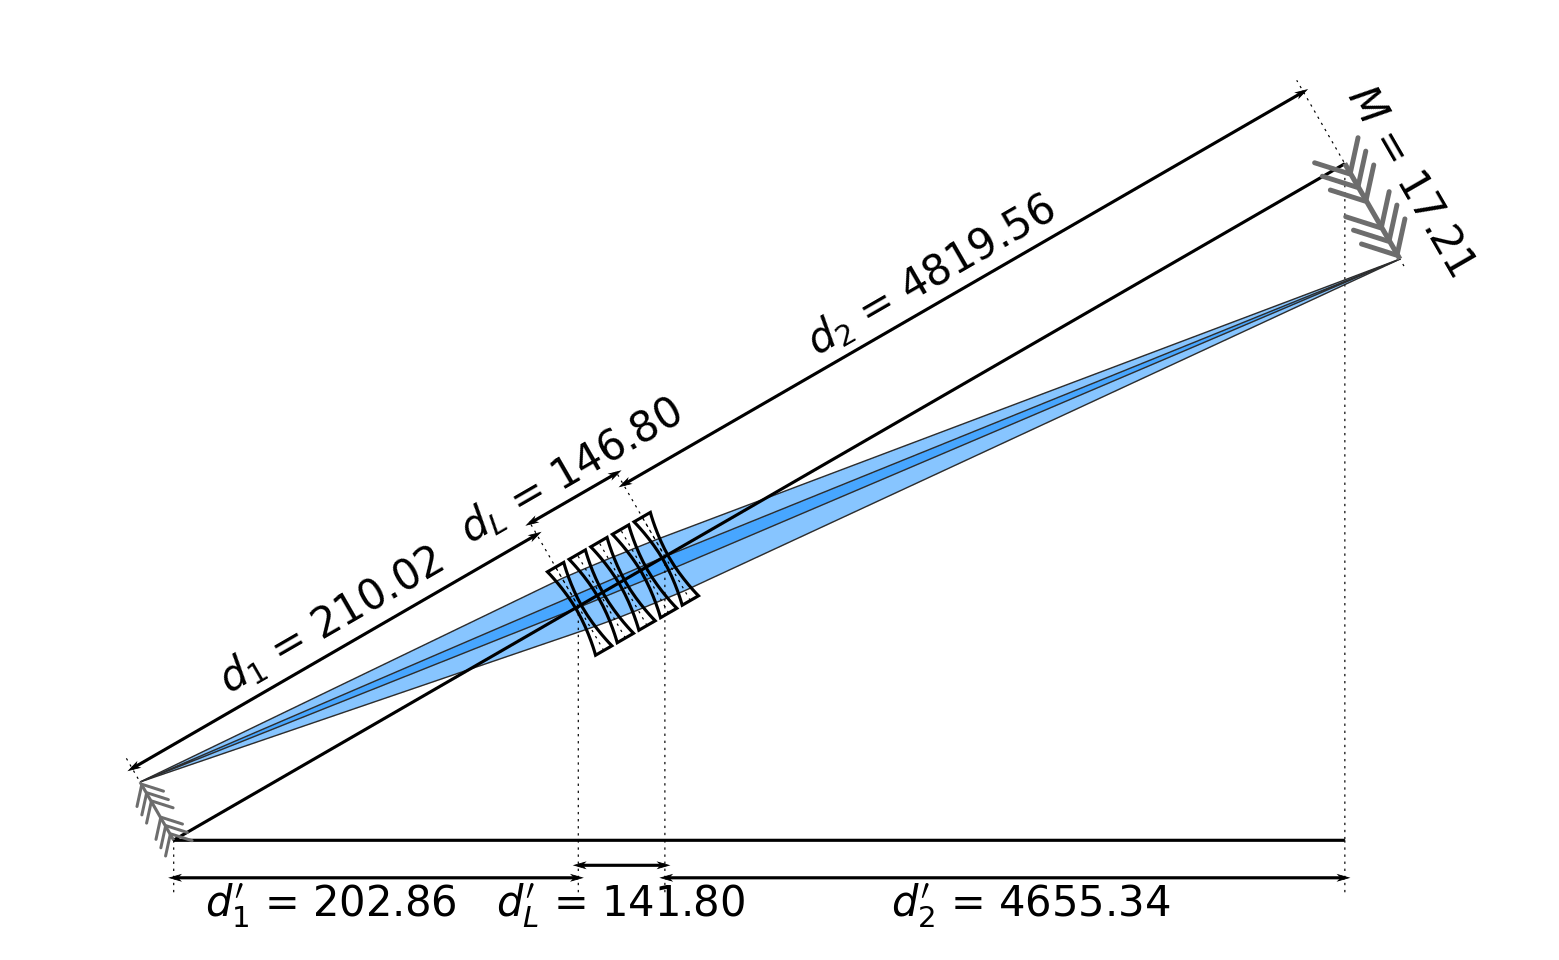

In [2]:
energy_kev = 17
two_theta = 15
d_tot = 5000/np.cos(np.radians(two_theta))
fig, ax = make_optics_geometry_plot(energy_kev, two_theta, d_tot)
fig.savefig('temp.png')


In [81]:
if not os.path.exists('cif_files'):
    os.makedirs('cif_files')
url = 'http://www.crystallography.net/cod/9008488.cif'
cif_file = 'cif_files/'+url.split('/')[-1]
if not os.path.isfile(cif_file):
    r = requests.get(url)
    open(cif_file , 'wb').write(r.content)

In [82]:
energy_kev = 17
xtl = Dans_Diffraction.Crystal(cif_file)

atom_type = xtl.Structure.type
occ = xtl.Structure.occupancy
natoms = np.sum(occ)
vol = xtl.Cell.volume()
atom_per_volume = 1 / vol  # atoms per A^3
elements = ['%s%s' % (at, o) for at, o in zip(atom_type, occ)]

n_comlex = Dans_Diffraction.fc.xray_refractive_index(elements, energy_kev, atom_per_volume)[0]
print(n_comlex)
print(Dans_Diffraction.fc.xray_refractive_index('Be', energy_kev, 1/16.225)[0])
print(elements)
print(atom_per_volume,2/16.225)

(0.9999988236531104-8.150857237112176e-11j)
(0.9999994118136966-4.075517715873505e-11j)
['Be1.0', 'Be1.0']
0.061631934570420585 0.12326656394453003


In [87]:
       

two_theta = 15.63
#obx = 231.4
mainx = 5000
d_tot = mainx / np.cos(np.radians(two_theta))
d0, dL, dn, M =  get_id06_be_lens_params(17,two_theta, d_tot)
print(d0, dL, dn, M)
print(d0 + dL + dn)

209.95471615698722 146.79999999999998 4835.23666914228 17.269883945895383
5191.991385299268


In [261]:
R = -50 #µm
d = 50
n = n_comlex.real
n = 1 -  1.1766230927939E-06 

f_inv = (n-1)*(2/R+(n-1)*d/(n*R*R))
f = 1/f_inv

print(f/10**4)

2124.7233242480224


In [151]:
R = -50 #µm
d = 50
n = n_comlex.real
delta = 1.1766230927939E-06 
n = 1 -  1.1766230927939E-06 

f_inv = (n-1)*(2/R+(n-1)*d/(n*R*R))
f = 1/f_inv

print(f/10**4)

2124.7233242480224


In [139]:
N = 50

F_inv = N*f_inv
F = 1/F_inv
F/10**4

42.494341471348356

In [142]:
f_inv = 1/2124.7170735674176/10**4
f = 1/f_inv
print(f/10**4)

2124.7170735674176


In [143]:
d = 1000# µm, periodicity

F_inv = f_inv
for i in range(1,N):
    D = d*(1+0.5*(i-1))
    F_inv = F_inv + f_inv - D*F_inv*f_inv

F = 1/F_inv
F/10**4

43.3341417920941

In [159]:
f_inv = -2*delta/R

F_0_inv = N*f_inv
F_0 = 1/F_0_inv
print(F_0/10**4)
normalised_lens_thickness = N*d/F_0
F = F_0 * np.sqrt(normalised_lens_thickness)/np.tan(np.sqrt(normalised_lens_thickness)) + N*d/2
print(F/10**4)

42.494491486882715
42.53612545125108


In [267]:
N = 88
TN = 68*1600 + 20*2000 # µm
R = 50# µm
δ = 1.1766230927939E-06 

f0 = R/(2*δ*N)
Λ = TN/f0 # µm/µm
f = f0*np.sqrt(Λ)/np.tan(np.sqrt(Λ))
print(f'f0 = {f0/1000:.2f} mm')
print(f'f  = {f/1000:.2f} mm')

f0 = 241.45 mm
f  = 189.68 mm


In [256]:
#https://physics.stackexchange.com/questions/247617/how-is-focal-length-defined-for-a-two-lens-system-separated-by-a-distance-d

ds = [1600]*68 +[2000]*20
#ds = [1690]*88# +[2.0]*20

f_inv = 2*δ/R
F_inv = f_inv

v_m_vmm = 0
for i, dist in enumerate(ds[:-1]):
    F_inv_pre = F_inv
    F_inv = F_inv + f_inv - (dist + v_m_vmm )*F_inv*f_inv
    v_m_vmm = (dist + v_m_vmm )/(1-δ)*F_inv_pre/F_inv
print(v_m_vmm/1000, 'mm')
F = 1/F_inv

F/1000

80.32521677730766 mm


267.44611312430715